# Analysis of massive re-refinement using RestraintLib sugar restraints

In this notebook we analyze the results of re-refining 641 PDB structures of nucleic acids. The initial experiment consisted of all 1169 structures between 1 Å and 3 Å found in the PDB as of November 1, 2019. From this set, structures with:

- less than 400 R-free reflections or
- more than 50% residues with alternative conformations or
- twinning 

were removed from the analysis, leaving 641 structures. Each structure was re-refined twice using 5 cycles of REFMAC - once using the default nucleic acids restraints, and once using the sugar restraints obtained from the RestraintLib server API.

First we read in the re-refinement results. We will analyze the R, R-free, RMSD(bonds), and RMSD(angles) after refinement.

In [1]:
import pandas as pd
import numpy as np

from plotnine import *
from scipy.stats import wilcoxon
from __future__ import print_function

In [2]:
def parse_report(report_file, resolutions_file="data/resolutions.csv"):
    rows = []

    with open(report_file, "r") as report_file:
        line_num = 0

        for line in report_file:
            line_type = line_num % 6

            if line_type == 0:
                row = []
                row.append(line.strip())
            elif line_type == 1:
                pass
            else:
                row.append(line.split()[2].strip())
                row.append(line.split()[3].strip())


            if line_type == 5:
                rows.append(row)

            line_num += 1

    df = pd.DataFrame(rows, dtype="float", 
                      columns=["PDB", "Initial R", "Final R", "Initial R-free", "Final R-free",
                               "Initial RMSD(bonds)", "Final RMSD(bonds)", "Initial RMSD(angles)", "Final RMSD(angles)"])
    df = df.set_index("PDB")
    
    resolutions_df = pd.read_csv(resolutions_file, index_col="PDB")
    df = df.join(resolutions_df, how="left")
    
    return df

def compare_results(combined_df):
    metric_set = ["Final R", "Final R-free", "Final RMSD(bonds)", "Final RMSD(angles)", "Initial RMSD(bonds)", "Initial RMSD(angles)"]
    metric_results = []

    for metric in metric_set:
        default = combined_df.loc[:, metric + default_suffix].astype(float)
        rl = combined_df.loc[:, metric + restraintlib_suffix].astype(float)
        test_result = wilcoxon(default, rl)

        metric_results.append([metric, 
                               np.sum((default - rl) > 0) / float(default.shape[0]) * 100, 
                               (default - rl).median(), 
                               ((1.0 - rl/default) *100).median(),
                               test_result.pvalue * len(metric_set)])
  
    comparison_df = pd.DataFrame(metric_results, 
                                 columns=["Metric", "RL Improvement ratio", "Median difference", "Median percentage change", "Wilcoxon p-value"])
    comparison_df = comparison_df.set_index("Metric")
    return comparison_df

Below, a sample of the results of running 5 cycles of REFMAC using default restraints:

In [3]:
default_df = parse_report("data/clean-report.txt")
default_df.to_csv("data/default_restraints.csv")
default_df.head()

,Initial R,Final R,Initial R-free,Final R-free,Initial RMSD(bonds),Final RMSD(bonds),Initial RMSD(angles),Final RMSD(angles),Resolution
PDB,,,,,,,,,
1csl,0.2091,0.1684,0.2379,0.2105,0.0045,0.0094,1.1210,1.6377,1.6
1d4r,0.2599,0.2404,0.2860,0.2799,0.0096,0.0081,1.4844,1.7277,2.0
1d9h,0.1701,0.1515,0.2198,0.1964,0.0137,0.0127,1.6227,1.8046,1.6
1dc0,0.2071,0.1931,0.2040,0.2057,0.0174,0.0165,1.9879,1.6592,1.3
1duh,0.2298,0.1922,0.2449,0.2306,0.0098,0.0097,1.2354,2.0013,2.7


Analogously, below a sample of the results of running 5 cycles of REFMAC using RestraintLib sugar restraints.

In [4]:
restraints_df = parse_report("data/RL-report.txt")
restraints_df.to_csv("data/sugar_restraints.csv")
restraints_df.head()

,Initial R,Final R,Initial R-free,Final R-free,Initial RMSD(bonds),Final RMSD(bonds),Initial RMSD(angles),Final RMSD(angles),Resolution
PDB,,,,,,,,,
1csl,0.2091,0.1684,0.2379,0.2101,0.0053,0.0087,1.0429,1.5366,1.6
1d4r,0.2599,0.2443,0.2860,0.2810,0.0102,0.0071,1.4779,1.4443,2.0
1d9h,0.1701,0.1521,0.2198,0.1975,0.0144,0.0120,1.5245,1.6601,1.6
1dc0,0.2071,0.1935,0.2040,0.2064,0.0189,0.0155,1.8319,1.3968,1.3
1duh,0.2298,0.1979,0.2449,0.2347,0.0108,0.0096,1.1922,1.6773,2.7


We combine the both result files into one dataframe for comparison.

In [5]:
default_suffix = " (default)"
restraintlib_suffix = " (RestraintLib)"
combined_df = default_df.join(restraints_df, lsuffix=default_suffix, rsuffix=restraintlib_suffix)
combined_df.head()

,Initial R (default),Final R (default),Initial R-free (default),Final R-free (default),Initial RMSD(bonds) (default),Final RMSD(bonds) (default),Initial RMSD(angles) (default),Final RMSD(angles) (default),Resolution (default),Initial R (RestraintLib),Final R (RestraintLib),Initial R-free (RestraintLib),Final R-free (RestraintLib),Initial RMSD(bonds) (RestraintLib),Final RMSD(bonds) (RestraintLib),Initial RMSD(angles) (RestraintLib),Final RMSD(angles) (RestraintLib),Resolution (RestraintLib)
PDB,,,,,,,,,,,,,,,,,,
1csl,0.2091,0.1684,0.2379,0.2105,0.0045,0.0094,1.1210,1.6377,1.6,0.2091,0.1684,0.2379,0.2101,0.0053,0.0087,1.0429,1.5366,1.6
1d4r,0.2599,0.2404,0.2860,0.2799,0.0096,0.0081,1.4844,1.7277,2.0,0.2599,0.2443,0.2860,0.2810,0.0102,0.0071,1.4779,1.4443,2.0
1d9h,0.1701,0.1515,0.2198,0.1964,0.0137,0.0127,1.6227,1.8046,1.6,0.1701,0.1521,0.2198,0.1975,0.0144,0.0120,1.5245,1.6601,1.6
1dc0,0.2071,0.1931,0.2040,0.2057,0.0174,0.0165,1.9879,1.6592,1.3,0.2071,0.1935,0.2040,0.2064,0.0189,0.0155,1.8319,1.3968,1.3
1duh,0.2298,0.1922,0.2449,0.2306,0.0098,0.0097,1.2354,2.0013,2.7,0.2298,0.1979,0.2449,0.2347,0.0108,0.0096,1.1922,1.6773,2.7


Below a statistical comparison of results using the default and the proposed restraints.

In [6]:
comparison_df = compare_results(combined_df)
comparison_df.style.format({'RL Improvement ratio': "{:.2f}%", 'Median difference': "{:.4f}",
                            'Median percentage change': "{:.2f}%", 'Wilcoxon p-value': "{:.3f}"})

,RL Improvement ratio,Median difference,Median percentage change,Wilcoxon p-value
Metric,,,,
Final R,7.80%,-0.0007,-0.36%,0.000
Final R-free,45.40%,0.0000,0.00%,0.238
Final RMSD(bonds),71.92%,0.0004,2.78%,0.000
Final RMSD(angles),88.61%,0.1049,5.26%,0.000
Initial RMSD(bonds),18.10%,-0.0001,-0.38%,0.000
Initial RMSD(angles),89.24%,0.0456,2.39%,0.000


Finally, let us analyze how the restraints compare at different resolutions. To obtain reasonably-sized samples, we will group resolutions to the closest 0.25 Å.

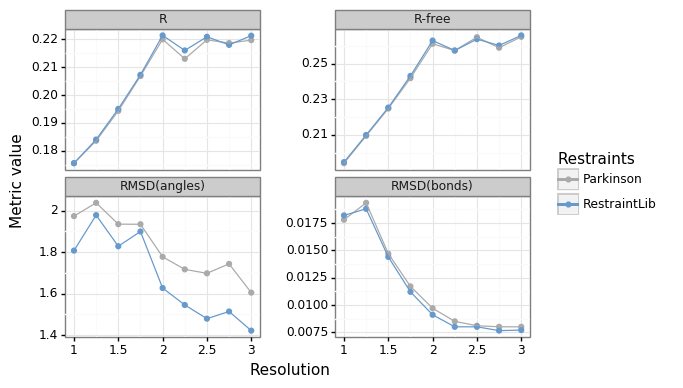

In [7]:
default_marked_df = default_df.loc[:, ["Resolution", "Final R", "Final R-free", "Final RMSD(bonds)", "Final RMSD(angles)"]]
default_marked_df.columns = ["Resolution", "R", "R-free", "RMSD(bonds)", "RMSD(angles)"]
default_marked_df.loc[:, "Restraints"] = "Parkinson"

restraints_marked_df = restraints_df.loc[:, ["Resolution", "Final R", "Final R-free", "Final RMSD(bonds)", "Final RMSD(angles)"]]
restraints_marked_df.columns = ["Resolution", "R", "R-free", "RMSD(bonds)", "RMSD(angles)"]
restraints_marked_df.loc[:, "Restraints"] = "RestraintLib"

resolution_analysis_df = default_marked_df.append(restraints_marked_df)
resolution_analysis_df.loc[:, "Resolution"] = (resolution_analysis_df.loc[:, "Resolution"] * 4).round(0)/4
resolution_analysis_df = resolution_analysis_df.groupby(["Resolution", "Restraints"], as_index=False).median()
resolution_analysis_df = resolution_analysis_df.melt(id_vars=["Resolution", "Restraints"], var_name="Metric", value_name="Metric value")

resolution_analysis_df

plot = ggplot(data=resolution_analysis_df, mapping=aes(x="Resolution", y="Metric value", color="Restraints")) +\
    geom_point() + \
    geom_line() + \
    facet_wrap("~Metric", scales="free_y") + \
    scale_color_manual(["#AAAAAA", "#6699CC"]) + \
    theme_bw() + \
    theme(panel_spacing_x=0.75,
          axis_text_x=element_text(colour="black"), 
          axis_text_y=element_text(colour="black"))

import warnings
warnings.filterwarnings("ignore")
plot.draw();
ggsave(plot=plot, filename="rerefinement_analysis.svg")